In [ ]:
from pathlib import Path
import os

DAY = "20251201"
Version = "v1"

PROJECT_ROOT = Path(os.getenv("LLMSC_ROOT", ".")).resolve()

DATA_DIR = Path(os.getenv("LLMSC_DATA_DIR", PROJECT_ROOT / "input")).resolve()
OUT_DIR  = Path(os.getenv("LLMSC_OUT_DIR",  PROJECT_ROOT / "runs" / f"{DAY}.{Version}")).resolve()
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [ ]:
RANDOM_SEED = 42
import random, os
import numpy as np
random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print(f"🔒 Random seed set to {RANDOM_SEED} for reproducibility.")

🔒 Random seed set to 42 for reproducibility.


In [ ]:
import google.generativeai as genai
import scanpy as sc
import pandas as pd
import numpy as np
import scipy
import scipy.sparse
from scipy import io
import adjustText
import gc
import time
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from sklearn.metrics import confusion_matrix
from google.colab import userdata

import logging
logging.basicConfig(
    level=logging.INFO,
    format="%(levelname)s:%(name)s:%(message)s"
)

from llm_sc_curator import LLMscCurator
from llm_sc_curator.masking import FeatureDistiller

import warnings
warnings.filterwarnings("ignore")

In [ ]:
save_path =  OUT_DIR / "cd4_benchmark_data.h5ad"

print(f"\n Loading data...: {save_path}")
adata= sc.read_h5ad(save_path)
print("\nCell counts per cluster (Should be balanced approx ~300 if 3 datasets merged):")
print(adata.obs['meta.cluster'].value_counts().head(10))


 Loading data...: /runs/20251201.v1/cd4_benchmark_data.h5ad

Cell counts per cluster (Should be balanced approx ~300 if 3 datasets merged):
meta.cluster
CD4.c01.Tn.TCF7          300
CD4.c06.Tm.ANXA1         300
CD4.c07.Tm.ANXA2         300
CD4.c16.Tfh.CXCR5        300
CD4.c14.Th17.SLC4A10     300
CD4.c15.Th17.IL23R       300
CD4.c12.Tem.GZMK         300
CD4.c10.Tm.CAPG          300
CD4.c20.Treg.TNFRSF9     300
CD4.c17.TfhTh1.CXCL13    300
Name: count, dtype: int64


In [ ]:
# ==========================================
# Correct Label Generation Function
# Definition based on cluster IDs from Zheng et al. 2021
# ==========================================

def get_cd4_ground_truth(cluster_name: str) -> str:
    """
    Map Zheng et al. CD4 meta.cluster names to GT categories.

    We intentionally keep this mapping simple and deterministic, based only on
    the author-provided cluster names (Tn/Tm/Tem/Temra/Th17/Tfh/Treg/ISG).
    Finer biological nuances are handled at the scoring layer, not here.
    """
    s = str(cluster_name).lower()

    # 1) Regulatory / helper subsets
    if any(k in s for k in ["treg", "foxp3", "regulatory"]):
        return "CD4_Treg"
    if any(k in s for k in ["tfh", "follicular", "cxcl13", "cxcr5"]):
        return "CD4_Tfh"
    if any(k in s for k in ["th17", "il17", "rorc", "il23r"]):
        return "CD4_Th17"

    # 2) ISG & cycling axes
    if any(k in s for k in ["isg", "interferon", "ifit1"]):
        return "CD4_ISG"
    if any(k in s for k in ["cycling", "proliferating", "mki67", "top2a"]):
        return "CD4_Cycling"

    if "mix" in s:
        return "CD4_Other"

    # 3) Exhausted pool (if ever present in CD4 cluster IDs)
    if any(k in s for k in ["tex", "exhausted", "pdcd1"]):
        return "CD4_Exhausted"

    # 4) Naive / memory pools
    if "tn." in s or "naive" in s:
        return "CD4_Tn.Naive"
    if "temra" in s:
        return "CD4_Temra.EffMem"
    if "tem." in s:
        return "CD4_Tem.EffMem"
    if "tm." in s:
        return "CD4_Tm.EffMem"

    # 5) Fallback
    return "CD4_Other"


print("Applying CD4 Ground Truth Mapping...")
adata.obs['GT_Category'] = adata.obs['meta.cluster'].apply(get_cd4_ground_truth)

print(adata.obs['GT_Category'].value_counts())


Applying CD4 Ground Truth Mapping...
GT_Category
CD4_Tm.EffMem       1967
CD4_Treg            1041
CD4_Tn.Naive         637
CD4_Tfh              600
CD4_Th17             600
CD4_Other            437
CD4_Tem.EffMem       300
CD4_Temra.EffMem     270
CD4_ISG              153
Name: count, dtype: int64


  Clustering to identify lineages...


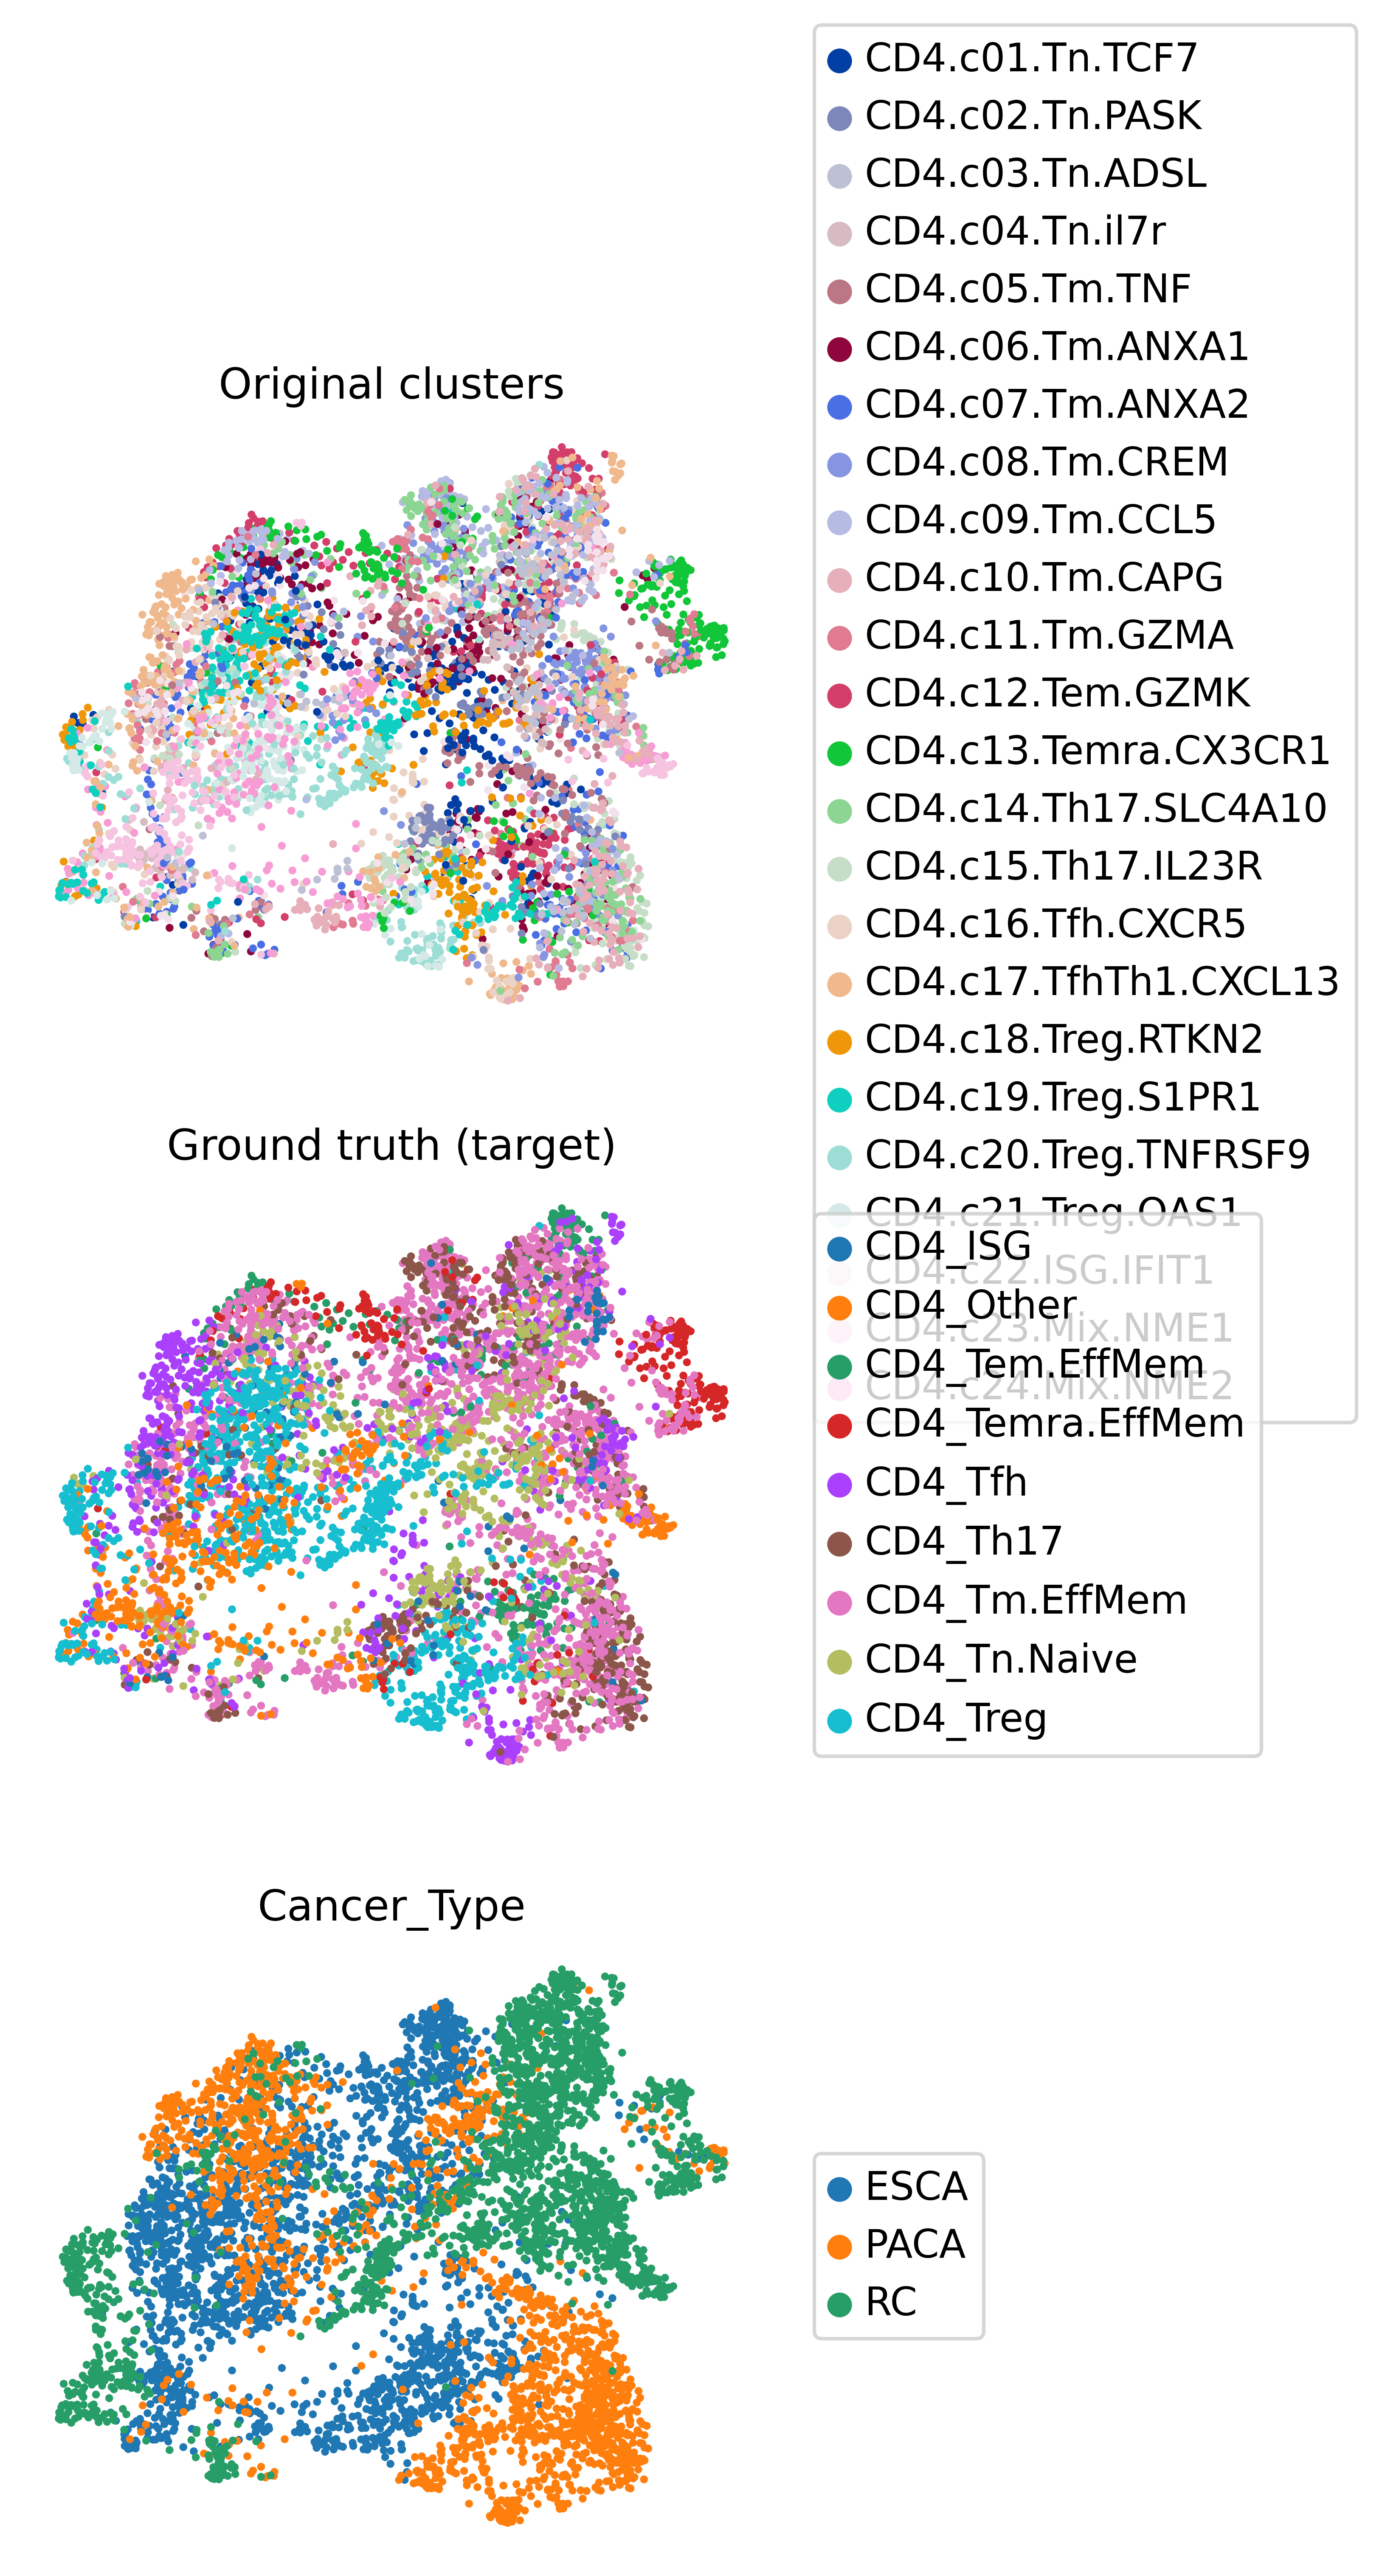

In [ ]:
print("  Clustering to identify lineages...")
sc.pp.neighbors(adata, random_state=42)
sc.tl.umap(adata, random_state=42)
fig = sc.pl.umap(
    adata,
    color=['meta.cluster', 'GT_Category', 'Cancer_Type'],
    legend_fontsize=10,
    ncols=1,
    title=['Original clusters', 'Ground truth (target)'],
    frameon=False,
    return_fig=True
)

for ax in fig.axes:
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(
            handles, labels,
            loc='center left',
            bbox_to_anchor=(1.05, 0.5),
            ncol=1,
        )

fig.set_size_inches(4, 10)
fig.tight_layout(rect=[0, 0, 0.85, 1])

fig.savefig(f"{OUT_DIR}/EDFig1c_CD4_GT_Check.pdf", bbox_inches='tight')

  Calculating dendrogram...
  Plotting DotPlot...
categories: CD4_ISG, CD4_Other, CD4_Tem.EffMem, etc.
var_group_labels: CD4_Tem.EffMem, CD4_Temra.EffMem, CD4_Tn.Naive, etc.
Done.


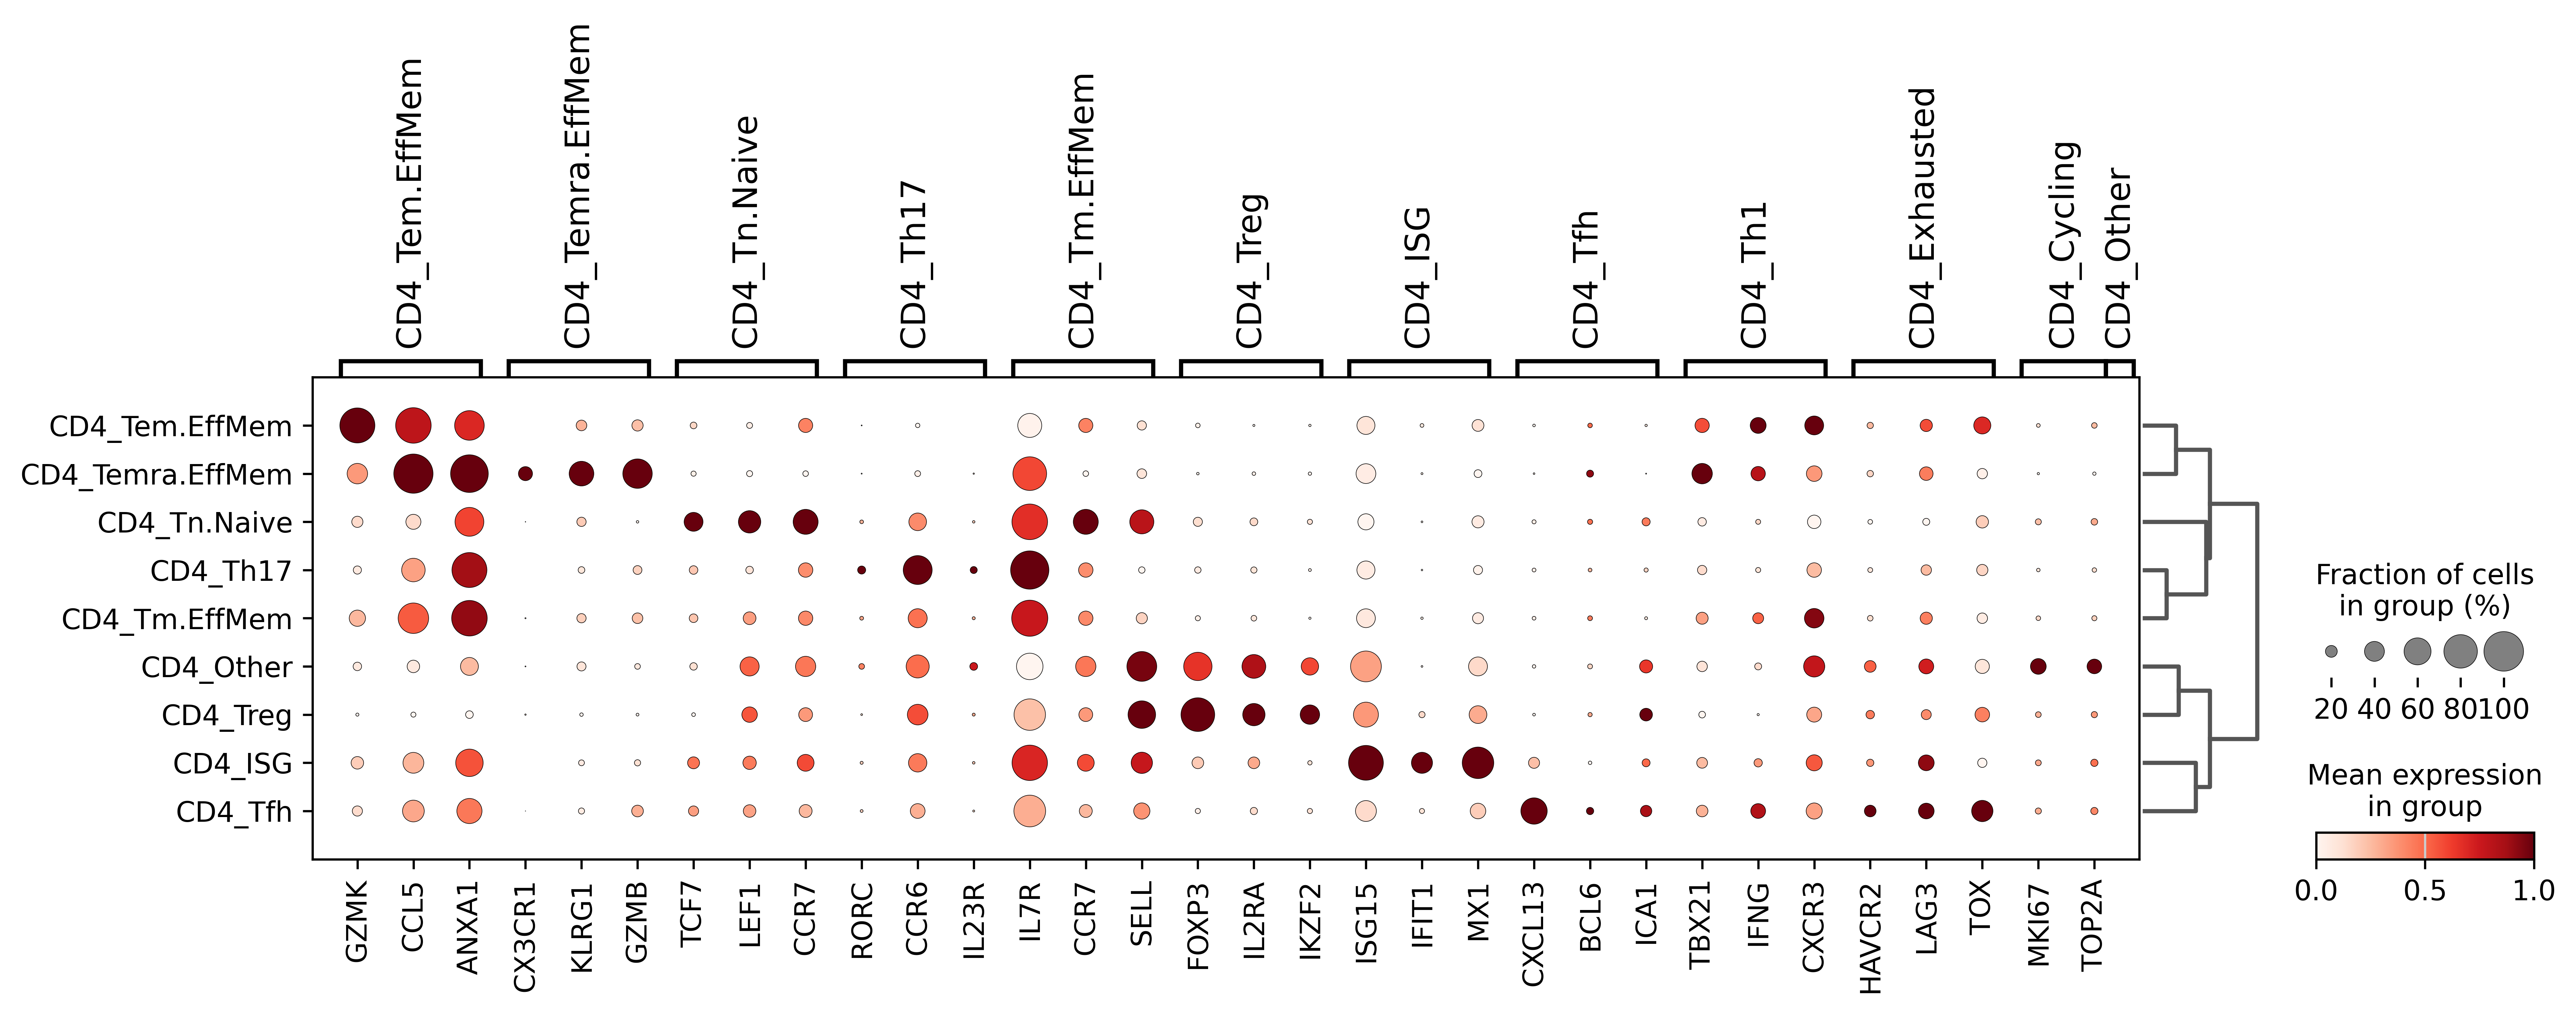

In [ ]:
GT_KEYWORDS_CD4 = {
    "CD4_Tem.EffMem":      ["GZMK", "CCL5", "ANXA1"],
    "CD4_Temra.EffMem":    ["CX3CR1", "KLRG1", "GZMB"],
    "CD4_Tn.Naive":        ["TCF7", "LEF1", "CCR7"],
    "CD4_Th17":            ["RORC", "CCR6", "IL23R"],
    "CD4_Tm.EffMem":       ["IL7R", "CCR7", "SELL"],
    "CD4_Treg":            ["FOXP3", "IL2RA", "IKZF2"],
    "CD4_ISG":             ["ISG15", "IFIT1", "MX1"],
    "CD4_Tfh":             ["CXCL13", "BCL6", "ICA1"],
    "CD4_Th1":             ["TBX21", "IFNG", "CXCR3"],
    "CD4_Exhausted":       ["HAVCR2", "LAG3", "TOX"],
    "CD4_Cycling":         ["MKI67", "TOP2A"],

    # Catch-all
    "CD4_Other":           [],
}

var_names = adata.var_names
filtered_markers = {k: [g for g in v if g in var_names] for k, v in GT_KEYWORDS_CD4.items()}

print("  Calculating dendrogram...")
sc.tl.dendrogram(adata, groupby='GT_Category')

print("  Plotting DotPlot...")
fig = sc.pl.dotplot(
    adata,
    filtered_markers,
    groupby='GT_Category',
    dendrogram=True,
    standard_scale='var',
    return_fig=True
)
fig.savefig(f"{OUT_DIR}/CD4_GT_Check.dod.pdf", bbox_inches='tight')
print("Done.")

  Calculating dendrogram...
  Plotting DotPlot...
categories: CD4_ISG, CD4_Other, CD4_Tem.EffMem, etc.
var_group_labels: CD4_Tem.EffMem, CD4_Temra.EffMem, CD4_Tn.Naive, etc.
Done.


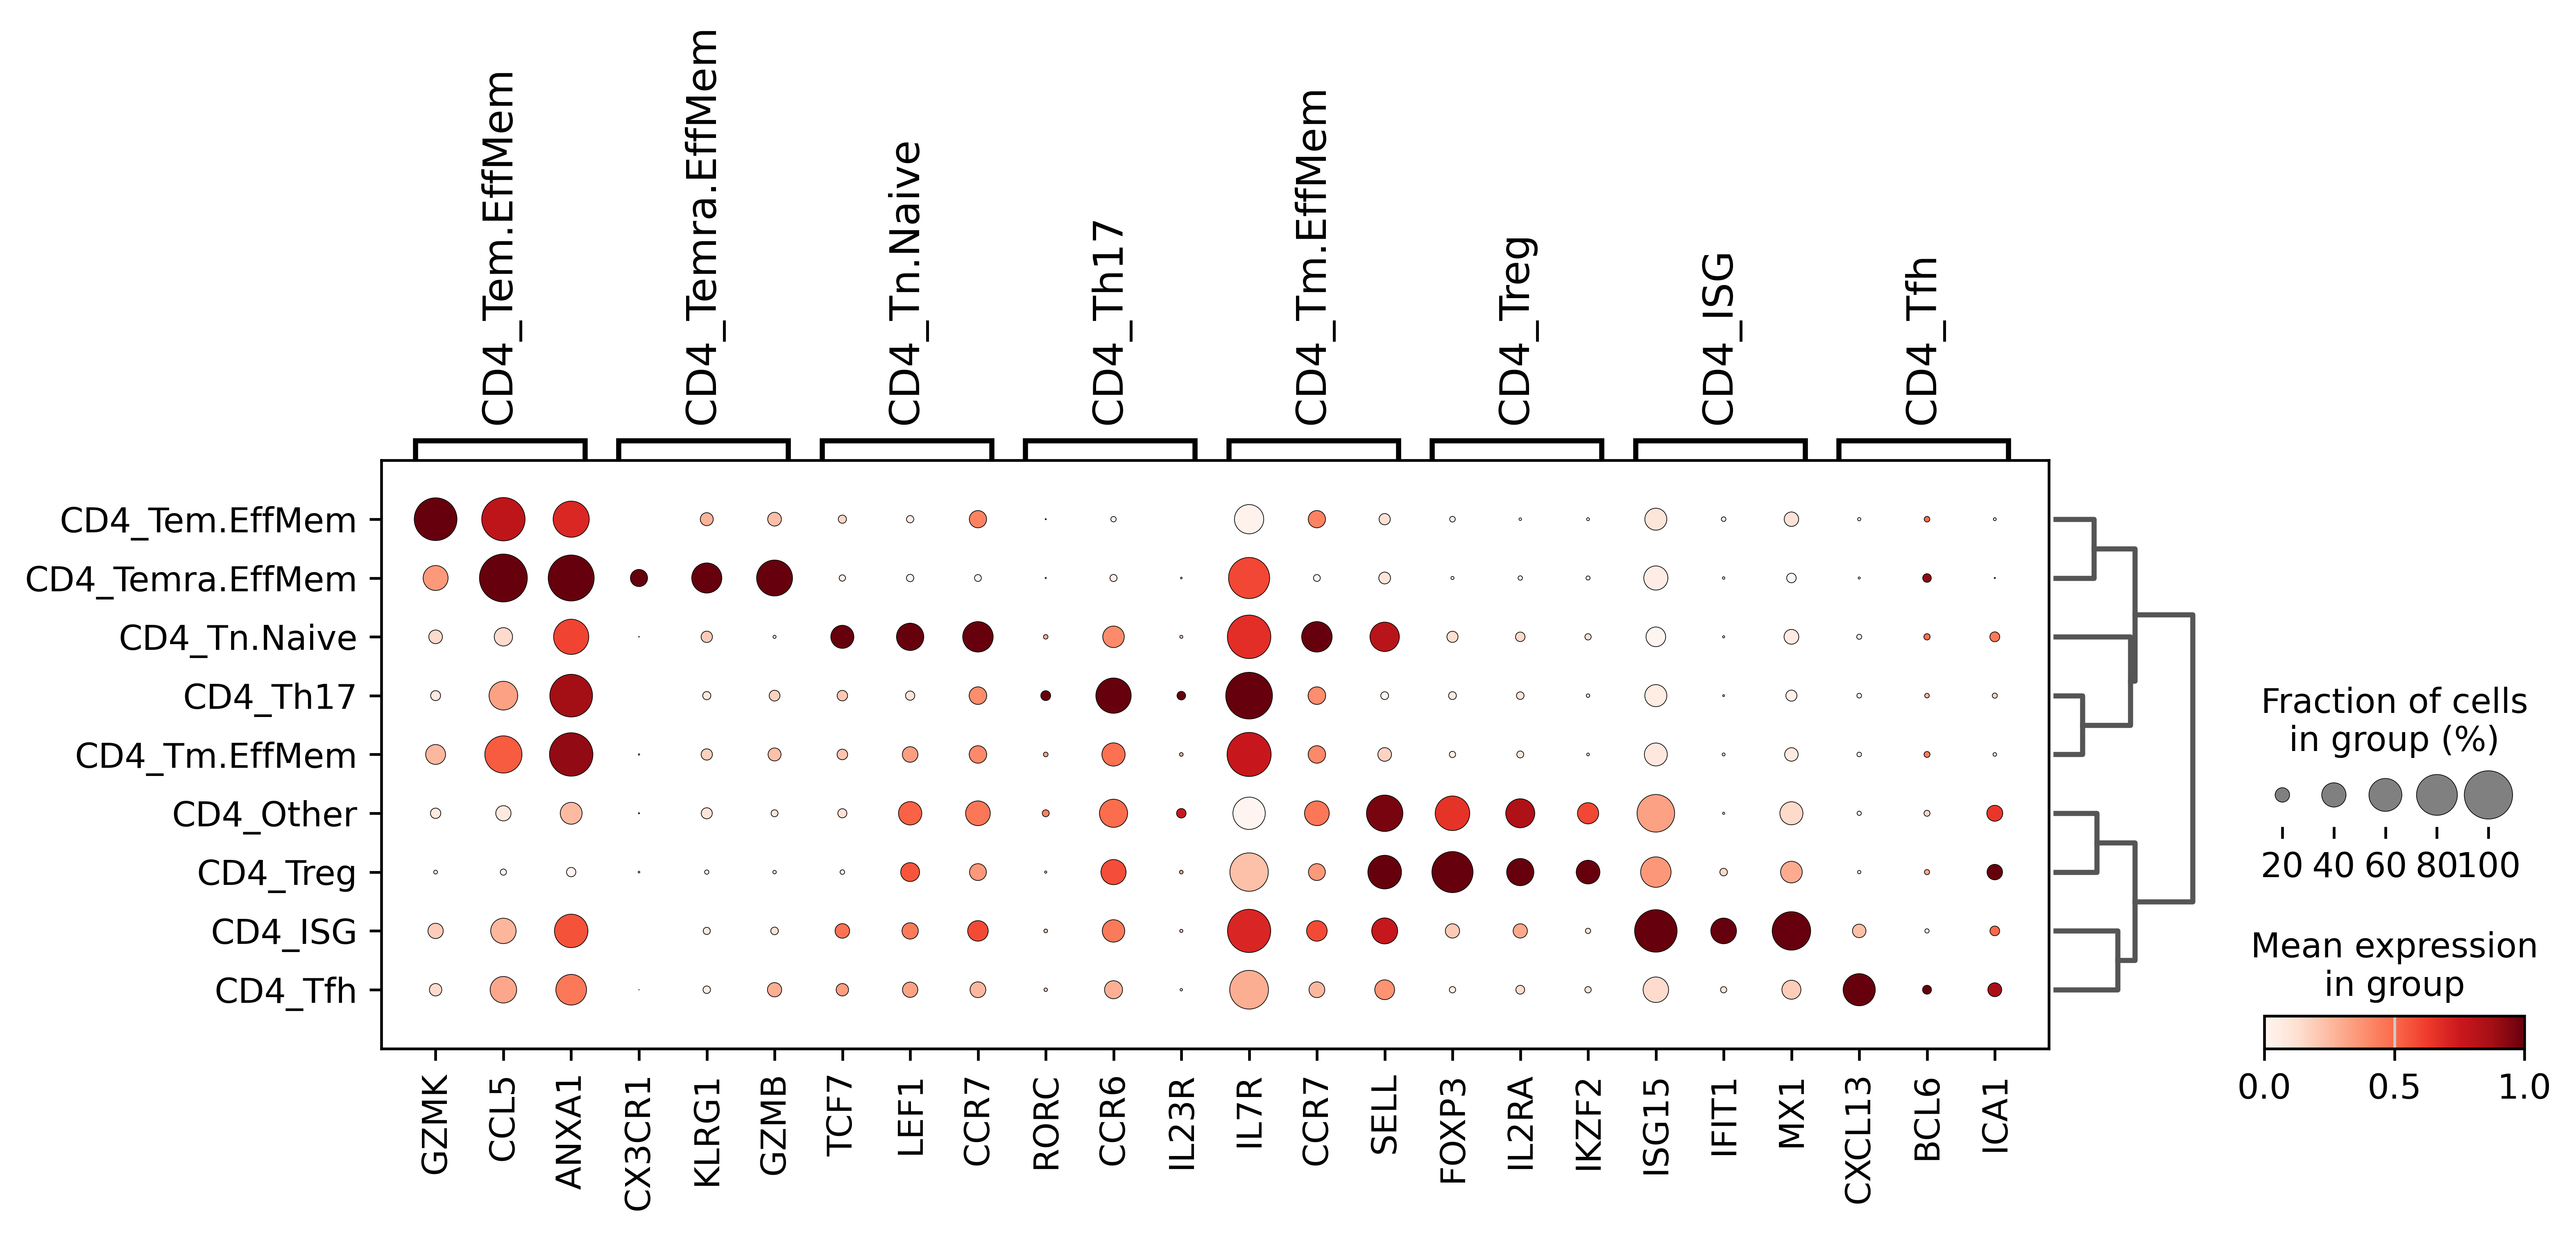

In [ ]:
GT_KEYWORDS_CD4 = {
    "CD4_Tem.EffMem":      ["GZMK", "CCL5", "ANXA1"],
    "CD4_Temra.EffMem":    ["CX3CR1", "KLRG1", "GZMB"],
    "CD4_Tn.Naive":        ["TCF7", "LEF1", "CCR7"],
    "CD4_Th17":            ["RORC", "CCR6", "IL23R"],
    "CD4_Tm.EffMem":       ["IL7R", "CCR7", "SELL"],
    "CD4_Treg":            ["FOXP3", "IL2RA", "IKZF2"],
    "CD4_ISG":             ["ISG15", "IFIT1", "MX1"],
    "CD4_Tfh":             ["CXCL13", "BCL6", "ICA1"],
    #"CD4_Th1":             ["TBX21", "IFNG", "CXCR3"],
    #"CD4_Exhausted":       ["HAVCR2", "LAG3", "TOX"],
    #"CD4_Cycling":         ["MKI67", "TOP2A"],

    # Catch-all
    #"CD4_Other":           [],
}

var_names = adata.var_names
filtered_markers = {k: [g for g in v if g in var_names] for k, v in GT_KEYWORDS_CD4.items()}

print("  Calculating dendrogram...")
sc.tl.dendrogram(adata, groupby='GT_Category')

print("  Plotting DotPlot...")
fig = sc.pl.dotplot(
    adata,
    filtered_markers,
    groupby='GT_Category',
    dendrogram=True,
    standard_scale='var',
    return_fig=True
)
fig.savefig(f"{OUT_DIR}/EDFig1g_CD4.pdf", bbox_inches='tight')
print("Done.")